# Counting Interactions

In order to analyze the data, we need to count the interactions between users. What we are interested in are the number of comments/postings between two users, the number of upvotes/downvotes of one user on another users posts, and the number of follows/ignores between two users. We will store these numbers in a new relationship type called `INTERACTION`.

## Setup

In [ ]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
driver = GraphDatabase.driver(uri)

## Postings

In [ ]:
with driver.session() as session:
    result = session.run('''
    MATCH (u1:User) -[:POSTED_BY]- (:Posting) -[:HAS_PARENT]- (:Posting) -[:POSTED_BY]- (u2:User)
    WHERE u1.id < u2.id
    WITH u1, u2, COUNT(*) AS postings
    MERGE (u1) -[i:INTERACTION]- (u2)
    SET i.postings = postings
''')

## Channels

In [ ]:
with driver.session() as session:
    result = session.run('''
    :auto
    CALL {
        MATCH (u1:User) -[:POSTED_BY]- (p1:Posting) -[:HAS_PARENT]- (p2:Posting) -[:POSTED_BY]- (u2:User)
        WHERE u1.id < u2.id
        UNWIND [p1, p2] AS p
        RETURN u1, u2, p
        UNION
        MATCH (u1:User) -[:(UPVOTED|DOWNVOTED)]- (p:Posting) -[:POSTED_BY]- (u2:User)
        WHERE u1.id < u2.id
        RETURN u1, u2, p
        UNION
        MATCH (u2:User) -[:(UPVOTED|DOWNVOTED)]- (p:Posting) -[:POSTED_BY]- (u1:User)
        WHERE u1.id < u2.id
        RETURN u1, u2, p
    }
    MATCH (p) -[:POSTED_ON]- (a:Article)
    WITH u1, u2, COUNT(DISTINCT a.channel) AS channels
    CALL {
        WITH u1, u2, channels
        MERGE (u1) -[i:INTERACTION]- (u2)
        SET i.channels = channels
    } IN TRANSACTIONS OF 1000 ROWS
''')

## Upvotes/Downvotes

In [ ]:
with driver.session() as session:
    result = session.run('''
    :auto
    CALL {
        MATCH (u1:User) -[:UPVOTED]- (:Posting) -[:POSTED_BY]- (u2:User)
        WHERE u1.id < u2.id
        RETURN u1, u2, COUNT(*) AS upvotes
        UNION ALL
        MATCH (u2:User) -[:UPVOTED]- (:Posting) -[:POSTED_BY]- (u1:User)
        WHERE u1.id < u2.id
        RETURN u1, u2, COUNT(*) AS upvotes
    }
    WITH u1, u2, SUM(upvotes) AS upvotes
    CALL {
        WITH u1, u2, upvotes
        MERGE (u1) -[i:INTERACTION]- (u2)
        SET i.upvotes = upvotes
    } IN TRANSACTIONS OF 1000 ROWS
''')

In [ ]:
with driver.session() as session:
    result = session.run('''
    :auto
    CALL {
        MATCH (u1:User) -[:DOWNVOTED]- (:Posting) -[:POSTED_BY]- (u2:User)
        WHERE u1.id < u2.id
        RETURN u1, u2, COUNT(*) AS downvotes
        UNION ALL
        MATCH (u2:User) -[:DOWNVOTED]- (:Posting) -[:POSTED_BY]- (u1:User)
        WHERE u1.id < u2.id
        RETURN u1, u2, COUNT(*) AS downvotes
    }
    WITH u1, u2, SUM(downvotes) AS downvotes
    CALL {
        WITH u1, u2, downvotes
        MERGE (u1) -[i:INTERACTION]- (u2)
        SET i.downvotes = downvotes
    } IN TRANSACTIONS OF 1000 ROWS
''')

## Following/Ignores

In [ ]:
with driver.session() as session:
    result = session.run('''
    CALL {
        MATCH (u1:User) -[:FOLLOWS]-> (u2:User)
        WHERE u1.id < u2.id
        RETURN u1, u2
        UNION ALL
        MATCH (u1:User) <-[:FOLLOWS]- (u2:User)
        WHERE u1.id < u2.id
        RETURN u1, u2
    }
    WITH u1, u2, COUNT(*) AS follows
    MERGE (u1) -[i:INTERACTION]- (u2)
    SET i.follows = follows
''')

In [ ]:
with driver.session() as session:
    result = session.run('''
    CALL {
        MATCH (u1:User) -[:IGNORES]-> (u2:User)
        WHERE u1.id < u2.id
        RETURN u1, u2
        UNION ALL
        MATCH (u1:User) <-[:IGNORES]- (u2:User)
        WHERE u1.id < u2.id
        RETURN u1, u2
    }
    WITH u1, u2, COUNT(*) AS ignores
    MERGE (u1) -[i:INTERACTION]- (u2)
    SET i.ignores = ignores
''')

## Export to CSV

In [ ]:
with driver.session() as session:
    result = session.run('''
    WITH "MATCH (u1:User) -[i:INTERACTION]- (u2:User)
        WHERE u1.id < u2.id
        RETURN 'u' + u1.id AS `:START_ID`, 'u' + u2.id AS `:END_ID`, i.postings AS `postings:long`, i.channels AS `channels:long`, i.upvotes AS `upvotes:long`, i.downvotes AS `downvotes:long`, i.follows AS `follows:long`, i.ignores AS `ignores:long`
        ORDER BY u1.id, u2.id" AS query
    CALL apoc.export.csv.query(query, "interaction.csv", {quotes: "ifNeeded"})
    YIELD file, source, format, nodes, relationships, properties, time, rows, batchSize, batches, done, data
    RETURN file, source, format, nodes, relationships, properties, time, rows, batchSize, batches, done, data
''')

Once the aggregation is done, we can export the `INTERACTION` relationship to a CSV file, so that it can be imported into the Neo4j database like the other relationships.

In [ ]:
!docker cp tie-strength-prediction-neo4j-1:/var/lib/neo4j/import/interaction.csv graph/

We can then copy the CSV files into our repository for later use.

## Analysis

Text(0.5, 1.0, 'Frequency of number of posting interactions')

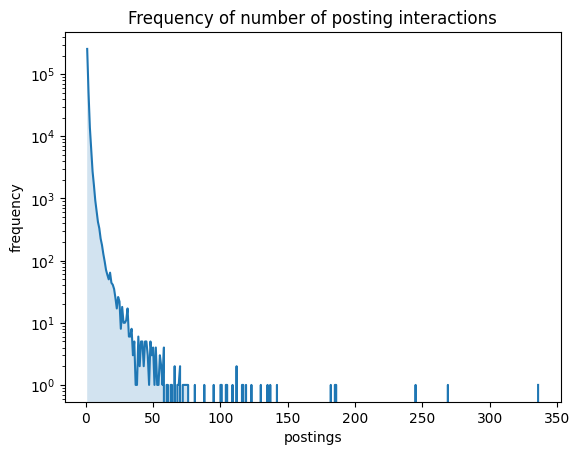

In [82]:
with driver.session() as session:
    result = pd.DataFrame(session.run('''
        MATCH (u1:User) -[i:INTERACTION]- (u2:User)
        WHERE u1.id < u2.id AND i.postings IS NOT NULL
        RETURN i.postings AS postings, COUNT(*) AS frequency
        ORDER BY postings
    ''').data())

index = np.arange(result.postings.min(), result.postings.max() + 1)
result.set_index('postings', inplace=True)
result = result.reindex(index).fillna(0).reset_index()

g = sns.lineplot(x='postings', y='frequency', data=result)
g.fill_between(result['postings'], result['frequency'], alpha=0.2)
g.set_yscale('log')
plt.title('Frequency of number of posting interactions')

Text(0.5, 1.0, 'Frequency of number of upvote interactions')

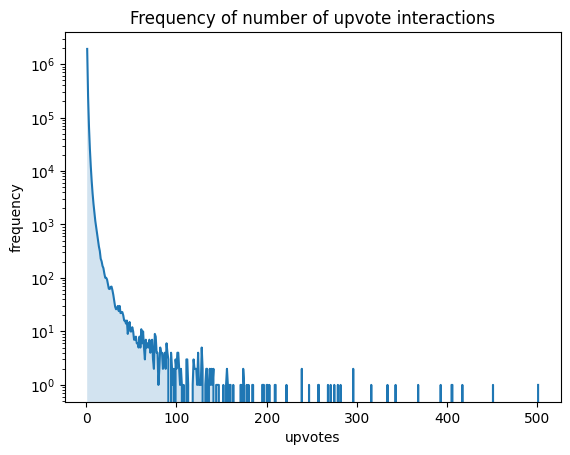

In [83]:
with driver.session() as session:
    result = pd.DataFrame(session.run('''
        MATCH (u1:User) -[i:INTERACTION]- (u2:User)
        WHERE u1.id < u2.id AND i.upvotes IS NOT NULL
        RETURN i.upvotes AS upvotes, COUNT(*) AS frequency
        ORDER BY upvotes
    ''').data())

index = np.arange(result.upvotes.min(), result.upvotes.max() + 1)
result.set_index('upvotes', inplace=True)
result = result.reindex(index).fillna(0).reset_index()

g = sns.lineplot(x='upvotes', y='frequency', data=result)
g.fill_between(result['upvotes'], result['frequency'], alpha=0.2)
g.set_yscale('log')
plt.title('Frequency of number of upvote interactions')

Text(0.5, 1.0, 'Frequency of number of downvote interactions')

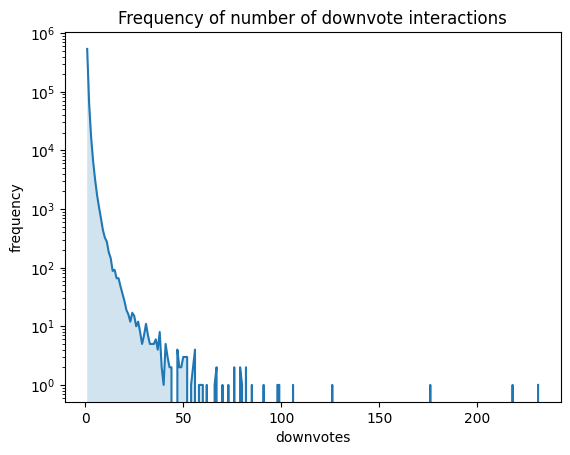

In [84]:
with driver.session() as session:
    result = pd.DataFrame(session.run('''
        MATCH (u1:User) -[i:INTERACTION]- (u2:User)
        WHERE u1.id < u2.id AND i.downvotes IS NOT NULL
        RETURN i.downvotes AS downvotes, COUNT(*) AS frequency
        ORDER BY downvotes
    ''').data())

index = np.arange(result.downvotes.min(), result.downvotes.max() + 1)
result.set_index('downvotes', inplace=True)
result = result.reindex(index).fillna(0).reset_index()

g = sns.lineplot(x='downvotes', y='frequency', data=result)
g.fill_between(result['downvotes'], result['frequency'], alpha=0.2)
g.set_yscale('log')
plt.title('Frequency of number of downvote interactions')

Text(0.5, 1.0, 'Frequency of number of channel interactions')

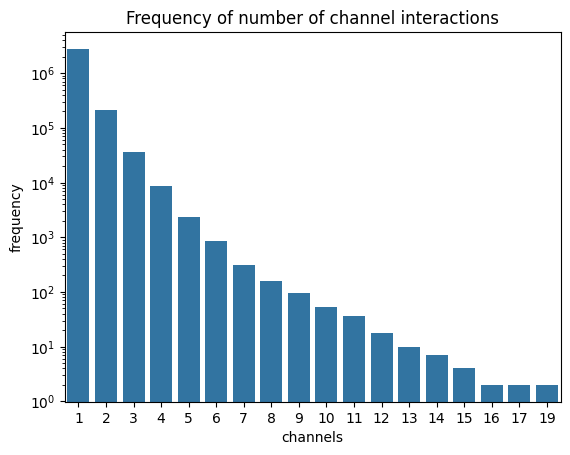

In [85]:
with driver.session() as session:
    result = pd.DataFrame(session.run('''
        MATCH (u1:User) -[i:INTERACTION]- (u2:User)
        WHERE u1.id < u2.id AND i.channels IS NOT NULL
        RETURN i.channels AS channels, COUNT(*) AS frequency
        ORDER BY channels
    ''').data())

g = sns.barplot(x='channels', y='frequency', data=result)
g.set_yscale('log')
plt.title('Frequency of number of channel interactions')

Text(0.5, 1.0, 'Frequency of following/ignoring types')

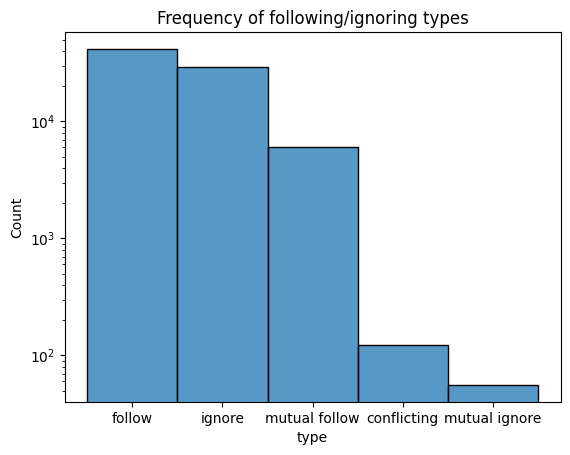

In [86]:
with driver.session() as session:
    result = pd.DataFrame(session.run('''
        MATCH (u1:User) -[i:INTERACTION]- (u2:User)
        WHERE u1.id < u2.id AND (i.follows IS NOT NULL OR i.ignores IS NOT NULL)
        WITH COALESCE(i.follows, 0) AS follows, COALESCE(i.ignores, 0) as ignores, COUNT(*) AS frequency
        RETURN CASE WHEN follows = 2 THEN 'mutual follow' WHEN ignores = 2 THEN 'mutual ignore' WHEN follows = 1 AND ignores = 1 THEN 'conflicting' WHEN follows = 1 THEN 'follow' WHEN ignores = 1 THEN 'ignore' ELSE 'none' END AS type, frequency
        ORDER BY frequency DESC
    ''').data())

g = sns.histplot(x='type', weights='frequency', data=result)
g.set_yscale('log')
plt.title('Frequency of following/ignoring types')

Text(0.5, 1.0, 'Frequency of interaction types')

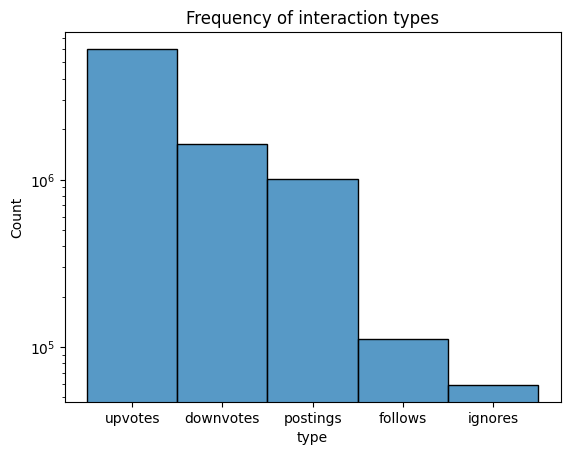

In [87]:
with driver.session() as session:
    result = pd.DataFrame(session.run('''
        MATCH () -[i:UPVOTED]- ()
        RETURN COUNT(*) AS frequency, 'upvotes' AS type
        UNION ALL
        MATCH () -[i:DOWNVOTED]- ()
        RETURN COUNT(*) AS frequency, 'downvotes' AS type
        UNION ALL
        MATCH () -[i:HAS_PARENT]- ()
        RETURN COUNT(*) AS frequency, 'postings' AS type
        UNION ALL
        MATCH () -[i:FOLLOWS]- ()
        RETURN COUNT(*) AS frequency, 'follows' AS type
        UNION ALL
        MATCH () -[i:IGNORES]- ()
        RETURN COUNT(*) AS frequency, 'ignores' AS type
    ''').data())

g = sns.histplot(x='type', weights='frequency', data=result)
g.set_yscale('log')
plt.title('Frequency of interaction types')

Text(0.5, 1.0, 'Frequency of number users interacting with')

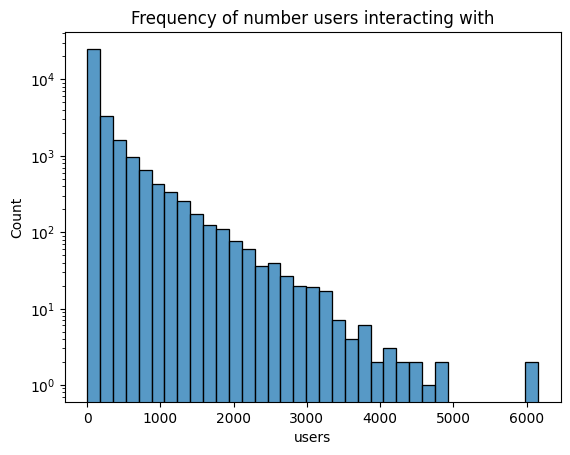

In [88]:
with driver.session() as session:
    result = pd.DataFrame(session.run('''
        MATCH (u1:User) -[i:INTERACTION]- (u2:User)
        WITH u1.id as user, COUNT(*) AS users
        RETURN users, COUNT(*) AS frequency
    ''').data())

g = sns.histplot(x='users', weights='frequency', data=result, bins='fd')
g.set_yscale('log')
plt.title('Frequency of number users interacting with')